In [1]:
import gym
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline

In [2]:
env = gym.make('Blackjack-v0')

## I. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [276]:
def draw_till_19_pol(obs):
    return [1,0] if obs[0]>=19 else [0,1]

def calc_payoffs(env,rounds,pol):

    average_payouts = []
    rd = 1
    total_payout = 0
    while rd <= rounds:
        is_done = False
        while not is_done:
            action = np.argmax(pol(env._get_obs()))
            obs, payout, is_done, _ = env.step(action)
            if is_done:
                total_payout += payout
                env.reset() # Сбросить окружение и раздать новые карты игроку и дилеру
                rd += 1
                average_payouts.append(total_payout / rd)

    plt.plot(average_payouts[1000:])                
    plt.xlabel('num_rounds')
    plt.ylabel('average payout')
    plt.show()    
    print ("Average payout of a player after {} rounds is {}".format(rounds, average_payouts[-1]))

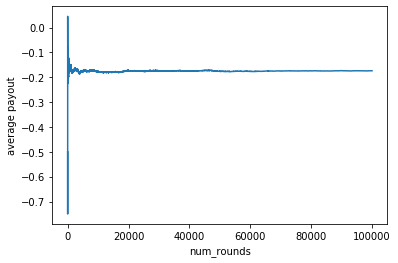

Average payout of a player after 100000 rounds is -0.17355826441735583


In [8]:
env = gym.make('Blackjack-v0', natural = True)
env.reset()
calc_payoffs(env,100000,draw_till_19_pol)

## В среднем простая стратегия дает проигрыш 17%, то есть казино примерно в 1,5 раза чаще выгрывает, чем стратегия выигрывает или играет в ничью. 

## Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

## 1. Создадим on-policy Monte Carlo Control

In [20]:
def create_epsilon_greedy_action_policy(env,Q,epsilon):
    """ Создание эпсилон жадной стратегии
    Args:
        env: Environment
        Q: Q table
        epsilon: Probability of selecting random action instead of the 'optimal' action 
    Returns:
        Epsilon-greedy-action Policy function with Probabilities of each action for each state
    """
    def policy(obs):
        nA = env.action_space.n
        P = np.ones(nA, dtype=float) * epsilon / nA  #инициализируем одинаковые вероятности для всех действий
        best_action = np.argmax(Q[obs])  #выбираем наилучшее действие
        P[best_action] = 1.0 - epsilon + (epsilon / nA)
        return P
    return policy

In [21]:
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon):
    """
    On-policy Monte Carlo Control, оптимизирующая эпсилон-жадную стратегию.   
    Args:
        env: Environment.
        episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state to action values.
        Policy is the trained policy that returns action probabilities
    """
    # Зафиксируем путь вознаграждений из каждого состояния и количество вхождений в каждое состояние
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # Словарь для фиксации action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Оптимизируемая эпсилон - жадная стратегия
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    
    for i in range(1, episodes + 1):
        # Выводим счетчик эпизодов
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)

        # Сгененрируем эпизод
        episode = []
        state = env.reset()
        is_done = False
        while not is_done:
            probs = pol(state) # берем вероятности сделать активность по стратегии 
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, is_done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        # Находим все пары (состояние, действие), в которых мы были в данном эпизоде
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            #First Visit MC:
            # Определяем первое появление пары (состояние, действие) в данном эпизоде
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Суммируем дисконтированные награды с момента первого появления в эпизоде
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Посчитаем среднее значение вознаграждений для конкретной пары (состояние, действие) по всем эпизодам
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    
    return Q, pol

In [31]:
env = gym.make('Blackjack-v0')
env.reset()
Q_on_pol,On_MC_Learned_Policy = On_pol_mc_control_learn(env, 1000000, 0.9, 0.05)

Episode 1000000/1000000.

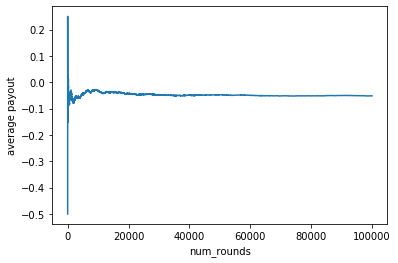

Average payout of a player after 100000 rounds is -0.05165948340516595


In [32]:
env.reset()
calc_payoffs(env,100000,On_MC_Learned_Policy)

## В среднем on-policy Monte Carlo Control стратегия дает проигрыш 5%, то есть казино примерно в 1,15 раза чаще выгрывает, чем стратегия выигрывает или играет в ничью. 

## 2. Создадим off-policy Monte Carlo Control с инкрементальным обновлением искомых функций

In [24]:
def create_random_policy(nA):
    """
    Создадим стратегию с одинаковыми вероятностями выбора действий 
    Args:
        nA: Number of actions in the environment.   
    Returns:
        A function that takes an observation state as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(obs):
        return A
    return policy_fn

def create_greedy_action_policy(env,Q):
    """ Создадим жадную стратегию
    Args:
        env: Environment
        Q: Q table 
    Returns:
        Greedy-action Policy function 
    """
    def policy(obs):
        P = np.zeros_like(Q[obs], dtype=float)
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] = 1
        return P
    return policy

def Off_pol_mc_control_learn(env, num_episodes, policy, discount_factor):
    """
    Monte Carlo Control Off-Policy Control, оптимизирующая жадную стратегию, используя Weighted Importance Sampling.  
    Args:
        env: Environment.
        num_episodes: Number of episodes to sample.
        policy: The policy to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.  
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Знаменатель в формуле weighted importance sampling
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Жадная стратегия
    target_policy = create_greedy_action_policy(env,Q)
        
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            clear_output(wait=True)

        episode = []
        state = env.reset()
        for t in range(100):
            # Выбираем действие по случайной стратегии
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Дисконтированные награды
        G = 0.0
        # Вес для наград
        W = 1.0
        # Двигаемся с конца эпизода
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Обновялем суммарные награды
            G = discount_factor * G + reward
            # Обновляем знаменатель в формуле weighted importance sampling
            C[state][action] += W
            # Обновляем инкрементально функуию action-value 
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # Если действие по случайной стратегии не совпадает с действию по целевой, то останавливаем расчет 
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./policy(state)[action]
        
    return Q, target_policy

In [29]:
env = gym.make('Blackjack-v0')
env.reset()
rand = create_random_policy(env.action_space.n)
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(env, 1000000, rand,0.9)

Episode 1000000/1000000.

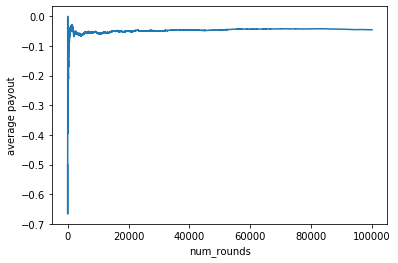

Average payout of a player after 100000 rounds is -0.045379546204537956


In [30]:
env.reset()
calc_payoffs(env,100000,off_MC_Learned_Policy)

## В среднем off-policy Monte Carlo Control стратегия дает проигрыш 4.5%, то есть казино примерно в 1,12 раза чаще выгрывает, чем стратегия выигрывает или играет в ничью. 

## 3. Создадим SARSA: on-policy TD Control

In [103]:
def create_epsilon_greedy_action_policy(env,Q,epsilon):
    """ Создадим эпсилон-жадную стратегию
    Args:
        env: Environment
        Q: Q table
        epsilon: Probability of selecting random action instead of the 'optimal' action
    Returns:
        Epsilon-greedy-action Policy function with Probabilities of each action for each state
    """
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n
        best_action = np.argmax(Q[obs])  
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

def SARSA(env, episodes, epsilon, alpha, gamma):
    """
    SARSA Learning Method
    Args:
        env: Environment
        episodes: Number of episodes to sample.
        epsilon: Probability of selecting random action instead of the 'optimal' action
        alpha: Learning Rate
        gamma: Gamma discount factor    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. 
    """
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i in range(1, episodes + 1):
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)
        eps = max(1.0 / i, epsilon) # сокращам эпсилон со временем, чтобы прийти к жадной стратегии
        curr_state = env.reset()
        probs = create_epsilon_greedy_action_policy(env,Q,eps)(curr_state)
        curr_act = np.random.choice(np.arange(len(probs)), p=probs)
        while True:
            next_state,reward,done,_ = env.step(curr_act)
            if not done: # Обновляем функцию Q с учетом следующего (состояния, действия), если игра не завершена
                next_probs = create_epsilon_greedy_action_policy(env,Q,eps)(next_state)
                next_act = np.random.choice(np.arange(len(next_probs)),p=next_probs)
                td_target = reward + gamma * Q[next_state][next_act]
                td_error = td_target - Q[curr_state][curr_act]
                Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
                curr_state = next_state
                curr_act = next_act
            if done: # Обновляем функцию Q только с учетом награды, если игра завершена
                td_error = reward - Q[curr_state][curr_act]
                Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
                break
            
    return Q, create_epsilon_greedy_action_policy(env,Q,eps)

In [111]:
env = gym.make('Blackjack-v0')
env.reset()
Q_SARSA,SARSA_Policy = SARSA(env, 1000000, 0.01, 0.009,1)

Episode 1000000/1000000.

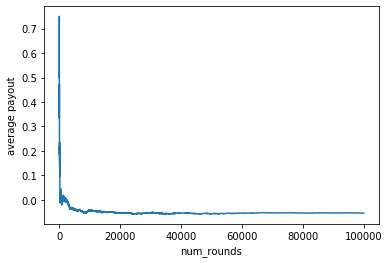

Average payout of a player after 100000 rounds is -0.053559464405355944


In [112]:
env.reset()
calc_payoffs(env,100000,SARSA_Policy)

## В среднем SARSA: on-policy TD Control стратегия дает проигрыш 5%, то есть казино примерно в 1,15 раза чаще выгрывает, чем стратегия выигрывает или играет в ничью. 

## 3. Создадим Q-Learning: off-policy TD Control

In [113]:
def off_pol_TD_Q_learn(env, episodes, epsilon, alpha, gamma):
    """
    Off-Policy TD Q-Learning Method
    Args:
        env: OpenAI gym environment.
        episodes: Number of episodes to sample.
        epsilon: Probability of selecting random action instead of the 'optimal' action
        alpha: Learning Rate
        gamma: Gamma discount factor
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. 
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i in range(1, episodes + 1):
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)
        eps = max(1.0 / i, epsilon) # сокращам эпсилон со временем, чтобы прийти к жадной стратегии
        curr_state = env.reset()
        while True:
            probs = create_epsilon_greedy_action_policy(env,Q,eps)(curr_state)
            curr_act = np.random.choice(np.arange(len(probs)), p=probs)
            next_state,reward,done,_ = env.step(curr_act)
            if not done: # Обновляем функцию жадно Q с учетом следующего (состояния, действия), если игра не завершена
                next_act = np.argmax(Q[next_state]) # жадно выбираем следующее действие
                td_target = reward + gamma * Q[next_state][next_act]
                td_error = td_target - Q[curr_state][curr_act]
                Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
                curr_state = next_state
            if done: # Обновляем функцию Q только с учетом награды, если игра завершена
                td_error = reward - Q[curr_state][curr_act]
                Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
                break
            
    return Q, create_epsilon_greedy_action_policy(env,Q,eps)

In [115]:
env = gym.make('Blackjack-v0')
env.reset()
Q_QLearn,QLearn_Policy = off_pol_TD_Q_learn(env, 1000000, 0.01, 0.1,0.95)

Episode 1000000/1000000.

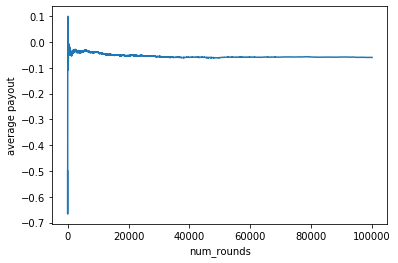

Average payout of a player after 100000 rounds is -0.05946940530594694


In [116]:
env.reset()
calc_payoffs(env,100000,QLearn_Policy)

## В среднем Q-Learning: off-policy TD Control стратегия дает проигрыш 6%, то есть казино примерно в 1,2 раза чаще выгрывает, чем стратегия выигрывает или играет в ничью. 

## II. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [284]:
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3) # Добавим третье действие
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(3)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:  # Удвоение: попросить у диллера карту и удвоить награду/проигрыш
            self.player.append(draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
            reward *= 2 # удвоение награды
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()
    
    def show_cards(self):
        return self.player

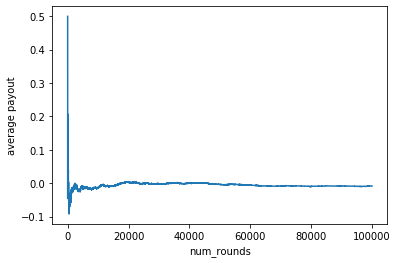

Average payout of a player after 100000 rounds is -0.008379916200837991


In [126]:
env = BlackjackEnv(True)
env.reset()
rand = create_random_policy(env.action_space.n)
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(env, 1000000, rand,0.9)
env.reset()
calc_payoffs(env,100000,off_MC_Learned_Policy)

## В среднем off-policy Monte Carlo Control стратегия с удвоением дает проигрыш 0,8%, то есть почти в ничью

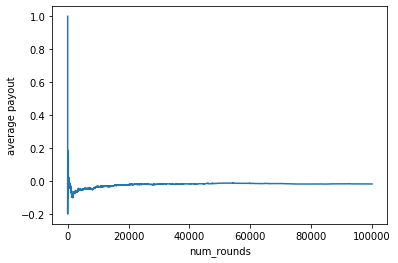

Average payout of a player after 100000 rounds is -0.017734822651773483


In [127]:
env = BlackjackEnv(True)
env.reset()
Q_on_pol,On_MC_Learned_Policy = On_pol_mc_control_learn(env, 1000000, 0.9, 0.05)
env.reset()
calc_payoffs(env,100000,On_MC_Learned_Policy)

## В среднем on-policy Monte Carlo Control стратегия с удвоением дает проигрыш 1,7%

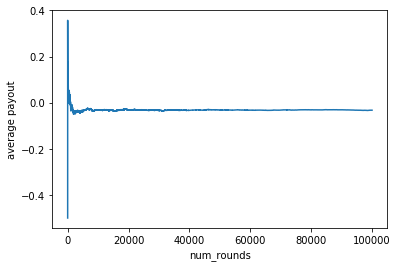

Average payout of a player after 100000 rounds is -0.032529674703252964


In [128]:
env = BlackjackEnv(True)
env.reset()
Q_SARSA,SARSA_Policy = SARSA(env, 1000000, 0.01, 0.009,1)
env.reset()
calc_payoffs(env,100000,SARSA_Policy)

## В среднем SARSA: on-policy TD Control стратегия с удвоением дает проигрыш 3%

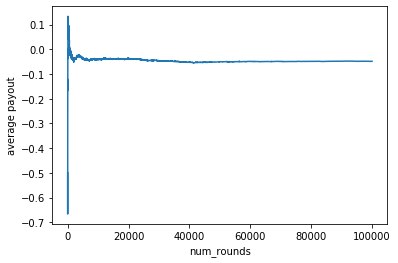

Average payout of a player after 100000 rounds is -0.04821951780482195


In [129]:
env = BlackjackEnv(True)
env.reset()
Q_QLearn,QLearn_Policy = off_pol_TD_Q_learn(env, 1000000, 0.01, 0.1,0.95)
env.reset()
calc_payoffs(env,100000,QLearn_Policy)

## В среднем Q-Learning: off-policy TD Control стратегия с удвоением дает проигрыш 5%

## III.I Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет). Давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт. Система подсчета "Плюс-минус"

In [234]:
class BlackjackEnvCardsAmount(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3) # Добавим третье действие
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(3)))
        self.seed()
        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        self.const_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.deck = self.const_deck*4
        self.plus_minus = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1,
                           7: 0, 8: 0, 9: 0, 10: -1, 1: -1} # словарь для подсчета карт в колоде
        

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def cards_count(self, deck):
        return len(deck)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:  # Удвоение: попросить у диллера карту и удвоить награду/проигрыш
            self.player.append(self.draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
            reward *= 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player)
                , np.sum([plus_minus[card] for card in self.deck])) # добавим расчет карт в колоде

    def reset(self):
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        
        if self.cards_count(self.deck) <= 15: # берем новую колоду, если осталось менее 15 карт в колоде
            self.deck = self.const_deck*4
        return self._get_obs()
    
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card) # удаляем карты при раздаче
        return card
    
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def show_cards(self):
        return self.player

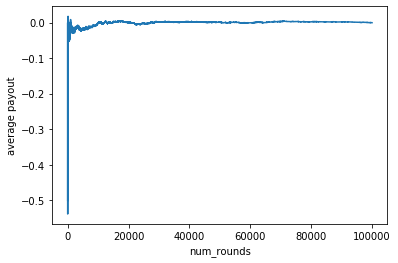

Average payout of a player after 100000 rounds is -3.999960000399996e-05


In [254]:
enw_new = BlackjackEnvCardsAmount(True)
enw_new.reset()
Q_on_pol,On_MC_Learned_Policy = On_pol_mc_control_learn(enw_new, 10000000, 0.9, 0.05)
enw_new.reset() 
calc_payoffs(enw_new,100000,On_MC_Learned_Policy)

## В среднем on-policy Monte Carlo Control стратегия с удвоением и подсчетом карт играет в ноль

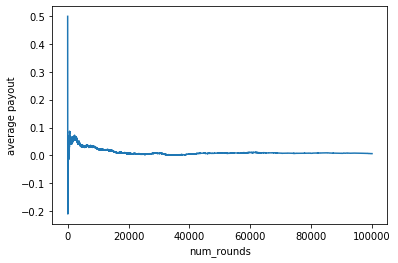

Average payout of a player after 100000 rounds is 0.006229937700622994


In [259]:
enw_new = BlackjackEnvCardsAmount(True)
enw_new.reset()
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(enw_new, 10000000, rand,0.9)
enw_new.reset()
calc_payoffs(enw_new,100000,off_MC_Learned_Policy)

## В среднем off-policy Monte Carlo Control стратегия с удвоением и подсчетом карт дает проигрыш 0,6%, то есть почти в ничью

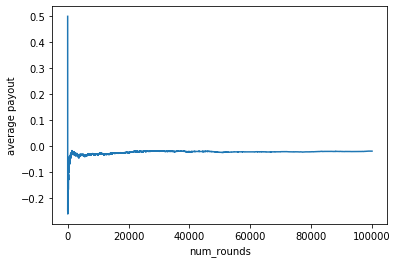

Average payout of a player after 100000 rounds is -0.01856981430185698


In [268]:
enw_new = BlackjackEnvCardsAmount(True)
enw_new.reset()
Q_SARSA,SARSA_Policy = SARSA(enw_new, 10000000, 0.01, 0.009,1)
enw_new.reset() 
calc_payoffs(enw_new,100000,SARSA_Policy)

## В среднем SARSA: on-policy TD Control стратегия с удвоением и подсчетом карт дает проигрыш 1,8%

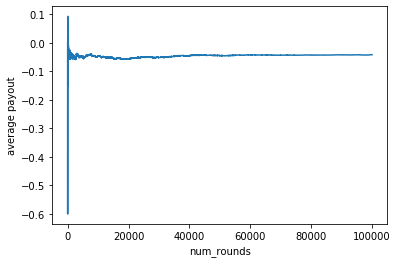

Average payout of a player after 100000 rounds is -0.041859581404185955


In [269]:
enw_new = BlackjackEnvCardsAmount(True)
enw_new.reset()
Q_QLearn,QLearn_Policy = off_pol_TD_Q_learn(enw_new, 10000000, 0.01, 0.1,0.95)
enw_new.reset() 
calc_payoffs(enw_new,100000,QLearn_Policy)

## В среднем Q-Learning: off-policy TD Control стратегия с удвоением и подсчетом карт дает проигрыш 4%

## III.II Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет). Давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт. Система подсчета "Половинки"

In [257]:
class BlackjackEnvHalf(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(3)))
        self.seed()
        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        self.const_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.deck = self.const_deck*4
        self.plus_minus = {2: 0.5, 3: 1, 4: 1, 5: 1.5, 6: 1,
                           7: 0.5, 8: 0, 9: -0.5, 10: -1, 1: -1}

        # Start the first game
        #self.reset()
        

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def cards_count(self, deck):
        return len(deck)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:  # double: draw a card and call for a dealer with a doubled reward
            self.player.append(self.draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
            reward *= 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player)
                , np.sum([plus_minus[card] for card in self.deck]))

    def reset(self):
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        
        if self.cards_count(self.deck) <= 15:
            self.deck = self.const_deck*4
        return self._get_obs()
    
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)
        return card
    
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def show_cards(self):
        return self.player

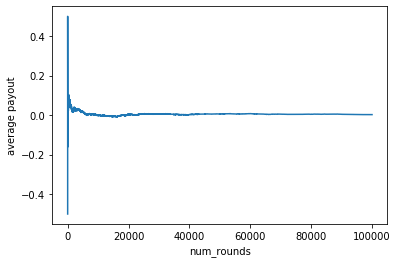

Average payout of a player after 100000 rounds is 0.0028099719002809974


In [260]:
enw_new = BlackjackEnvHalf(True)
enw_new.reset()
Q_off_Pol,off_MC_Learned_Policy = Off_pol_mc_control_learn(enw_new, 10000000, rand,0.9)
enw_new.reset()
calc_payoffs(enw_new,100000,off_MC_Learned_Policy)

## В среднем off-policy Monte Carlo Control стратегия с удвоением и подсчетом карт дает проигрыш 0,2%, то есть почти в ничью

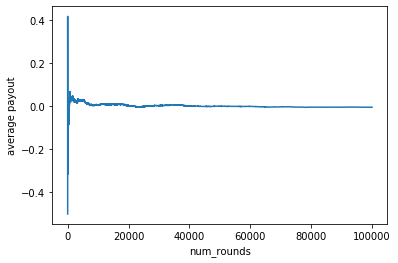

Average payout of a player after 100000 rounds is -0.004914950850491495


In [261]:
enw_new = BlackjackEnvHalf(True)
enw_new.reset()
Q_on_pol,On_MC_Learned_Policy = On_pol_mc_control_learn(enw_new, 10000000, 0.9, 0.05)
enw_new.reset() 
calc_payoffs(enw_new,100000,On_MC_Learned_Policy)

## В среднем on-policy Monte Carlo Control стратегия с удвоением и подсчетом карт дает проигрыш 0,5%, то есть почти в ничью

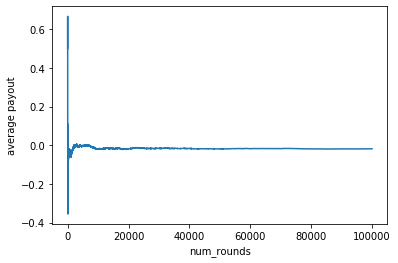

Average payout of a player after 100000 rounds is -0.017644823551764482


In [266]:
enw_new = BlackjackEnvHalf(True)
enw_new.reset()
Q_SARSA,SARSA_Policy = SARSA(enw_new, 10000000, 0.01, 0.009,1)
enw_new.reset() 
calc_payoffs(enw_new,100000,SARSA_Policy)

## В среднем SARSA: on-policy TD Control стратегия с удвоением и подсчетом карт дает проигрыш 1,7%

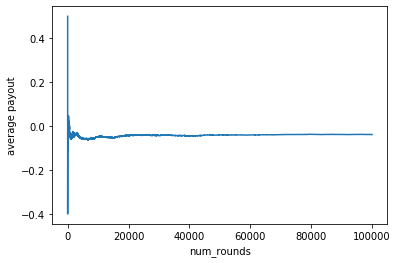

Average payout of a player after 100000 rounds is -0.038224617753822465


In [267]:
enw_new = BlackjackEnvHalf(True)
enw_new.reset()
Q_QLearn,QLearn_Policy = off_pol_TD_Q_learn(enw_new, 10000000, 0.01, 0.1,0.95)
enw_new.reset() 
calc_payoffs(enw_new,100000,QLearn_Policy)

## В среднем Q-Learning: off-policy TD Control стратегия с удвоением и подсчетом карт дает проигрыш 3,8%

## Лучшего результата получилось добиться с on-policy Monte Carlo Control стратегией с удвоением и подсчетом карт, которая играет в ноль с казино